In [2]:
import numpy as np 
import matplotlib.pyplot as plt 
from typing import Dict, List, Tuple

### ADD FIGURES AND DETAILED EXPLANATIONS AND IMPROVE THE NOTEBOOK AFTER COMPLETING THE CORE FUNCTIONALITY

#### usecases
- timeseries prediction and forecasting
- speech recognition
- image classification
----
so handles sequence data

#### there are various versions:
- many to many : machine translation
- many to one : sentiment analysis, image classification, SoH prediction
- one to many : image captioning

---
- applies cell's recursively, having a direction of time
---
- has exploding/vanishing gradient problems
- we'll use tanh + clipping to overcome exploding gradients, but may still lead to short-term memory retention due to vanishing gradients
- we'll use residual gradient pass in LSTM's to overcome this vanishing gradient problem

### RNN cell:
- can be likened to the basic unit that processes and stores information
over time. processes one element of the sequence at a time and maintains a "hidden state" that contains information about previous elements in the sequence. : 
    - inputs : h_(t-1) and x_t
    - combines: with associated weights and biases
    - applies: an activation function , commonly tanh
    - ouputs: new hidden state
    - passes: this new hidden state to either the next layer or to the output directly.
---
- we can have multiple layers of stacked RNNs to learn more complex data distributions
---
components & learnable parameters:
- hidden state vector(not learned, but computed along the way in both training and inference): h(t) i.e. the memory along time
- Wx = Wxh
- Wh = Whh
- Wy = Why
- bx
- by
--- 
- tanh as activation function btw hidden states
---


### now lets analyze the dimensions of our vectors and matrices
h(t) = tanh[x(t) * Wx + Wh * h(t-1) + b]
- here we are analyzing a single state of the cell's(taking a single input of input_dimX1(single x_t) dimension) dimension, and the n here refers to the n_neurons of hidden state. these components should be internalized and differentiated well.
thus : 
- x(t) : 1 x 1
- Wx   : n x 1
- b    : n x 1 (has to maintain the shape due to sum operation)
- h(t) : n x 1 (since tanh doesnt alter the dimension)
- h(t-1) : n x 1 (since this is also a hidden state like h(t), just previous timestamp)
- Wh   : n x n (the ones above yields this dimension)



### now lets create an artificial timeseries dataset, with random noise

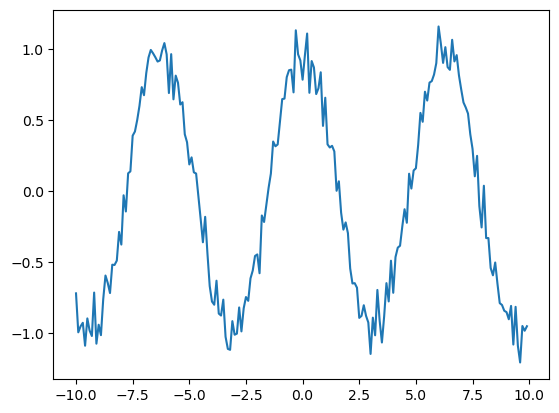

In [4]:
X_t = np.arange(-10,10,0.1).reshape(-1,1)
Y_t = np.cos(X_t) + 0.1*np.random.randn(X_t.shape[0],1)

plt.plot(X_t, Y_t)
plt.show()


### now, lets start to build each component of our Vanilla Rnn: single layer RNN

In [4]:
class VanillaRNN:
    """many to many Vanilla RNN"""
    def __init__(self, X_t:np.ndarray, n_neurons:int):
        """
        Parameters:
        X_t (numpy.ndarray): Input time-series data of shape (T, input_size), where T is the number of time steps.
        n_neurons (int): Number of neurons in the hidden layer.
        
        """
        self.T, self.input_size = X_t.shape # of time steps & # of features in the input
        # here input size like price: 1 or  (temperature and humidity) : 2
        # or for Word Sequence Data : dimensionality of the word embeddings
        self.n_neurons = n_neurons # hidden_size = # of units in the RNN cell layer
        self.X_t = X_t  
        self.Y_hat = np.zeros((self.T,1))# we are predicting T scalar y's, it could be 
        # like outputting a word vector like #T y's of dim output_size.

        # Initialize the hidden states for all time steps (plus one for initial state)
        self.H = [np.zeros((n_neurons,1)) for _ in range(self.T + 1)]


        # initialize the weights
        self.Wx = 0.1*np.random.randn(n_neurons,self.input_size)
        self.Wh = 0.1*np.random.randn(n_neurons,n_neurons)
        self.Wy = 0.1*np.random.randn(1,n_neurons)
        self.bh = 0.1*np.random.randn(n_neurons,1)
        self.by = 0.1*np.random.randn(1,1)
        
    def forward(self, x_t: np.ndarray, h_t_1: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """
        Forward pass for a single time step.

        Parameters:
        -----------
        x_t (np.ndarray): Input data at time step t of shape `(input_size, 1)`.
        h_t_1 (np.ndarray): Hidden state from the previous time step `(n_neurons, 1)`.

        Returns:
        --------
        h_t (np.ndarray): Hidden state at time step t `(n_neurons, 1)`.
        y_t_hat (np.ndarray): Predicted output at time step t `(output_size, 1)`.
        """
        # Compute the linear combination
        out = np.dot(self.Wx, x_t) + np.dot(self.Wh, h_t_1) + self.bh
        # Apply tanh activation to produce the hidden state
        h_t = np.tanh(out)
        # Compute the output
        y_t_hat = np.dot(self.Wy, h_t) + self.by

        return h_t, y_t_hat

    def full_forward(self)->np.ndarray:
        
        for t in range(self.T):
            x_t = self.X_t[t].reshape(-1,1)

            # hidden state at time: t
            self.H[t+1] = np.tanh(
                np.dot(self.Wx,x_t) +
                np.dot(self.Wh,self.H[t])+
                self.bh
            )
            self.Y_hat[t] = np.dot(self.Wy,self.H[t+1]) + self.by
        return self.H, self.Y_hat


In [99]:
model = VanillaRNN(X_t,n_neurons=64)
model.Y_hat.shape, len(model.H),model.H[0].shape, model.Wx.shape, model.Wh.shape

((400, 1), 401, (64, 1), (64, 1), (64, 64))

In [57]:
model.X_t[0:4]

array([[-20. ],
       [-19.9],
       [-19.8],
       [-19.7]])

In [64]:
model.full_forward()[0:4]
# this is full forward pass

array([[-0.61804281],
       [-0.64603102],
       [-0.75615447],
       [-0.90425815]])

In [68]:
h1,y_hat_1 = model.forward(X_t[0],0)
h1,y_hat_1

# this is the first step forward, producing the h_1 and y_hat_1 
# can be used to look inside the RNN cell and aid debugging

(array([[ 0.04802838,  0.572629  ,  0.92190003, ...,  0.98675603,
          0.76403692, -0.60615494],
        [-0.18729974,  0.39171405,  0.87730313, ...,  0.9787846 ,
          0.64590476, -0.73541655],
        [-0.13694935,  0.43459285,  0.88868989, ...,  0.98084954,
          0.67504907, -0.71075156],
        ...,
        [ 0.00996895,  0.54646671,  0.91597663, ...,  0.98571499,
          0.74771226, -0.62969855],
        [-0.13157178,  0.43902424,  0.88983559, ...,  0.98105617,
          0.67801886, -0.70803115],
        [-0.05642501,  0.49817473,  0.90460277, ...,  0.98370099,
          0.71692641, -0.66813729]]),
 array([[-0.11500548, -0.15456133, -0.11801533,  0.0573181 , -0.15301535,
         -0.11219897, -0.11903721, -0.10751376, -0.11986535, -0.14916963,
         -0.14837393, -0.0916531 ,  0.14519081, -0.1061228 ,  0.18006838,
         -0.10089914,  0.19079097, -0.10391787,  0.10979498, -0.10463146,
         -0.12607208, -0.10351054, -0.1478227 ,  0.14892714, -0.11390324,
   

In [70]:
h2,y_hat_2 = model.forward(X_t[1],h1)
h2,y_hat_2

(array([[ 0.08687015,  0.05670943,  0.50030071, ...,  0.8768164 ,
          0.16346183,  0.05443571],
        [-0.2438172 ,  0.14489653,  0.74829741, ...,  0.95148064,
          0.40529111, -0.61044955],
        [-0.18917713,  0.06380654,  0.65683961, ...,  0.92832943,
          0.28578291, -0.45624696],
        ...,
        [-0.08804152,  0.47537986,  0.90475069, ...,  0.98388999,
          0.70928053, -0.6455464 ],
        [-0.10870559, -0.15423899,  0.3207251 , ...,  0.81594003,
         -0.05085091, -0.1121026 ],
        [-0.03227943,  0.72588456,  0.97050819, ...,  0.99547027,
          0.8857259 , -0.83711798]]),
 array([[-0.10864996, -0.1191851 , -0.1613702 ,  0.12682568, -0.12263359,
         -0.15616673, -0.16157697, -0.14421313, -0.16162573, -0.12963187,
         -0.13097648, -0.08302598,  0.19729559, -0.13850942,  0.20374812,
         -0.10103123,  0.1909939 , -0.12646039,  0.17305055, -0.13082986,
         -0.15931306, -0.12373222, -0.13189419,  0.19931856, -0.15853611,
   

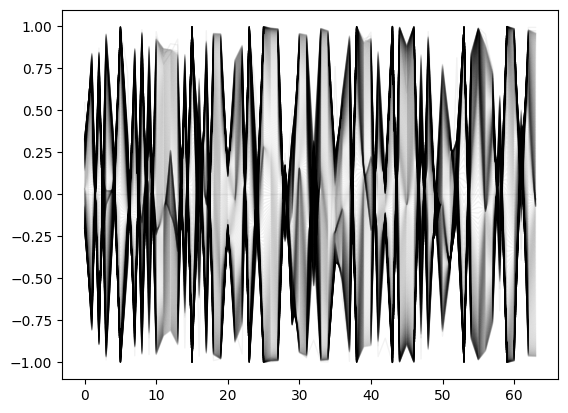

In [100]:
H,Y_hat = model.full_forward()
# lets plot the states of all neurons
for h in H:
    plt.plot(np.arange(64),h,
             'k-',linewidth=1,alpha=0.05)


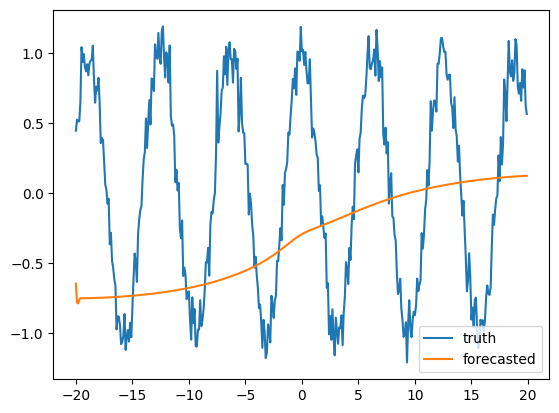

In [101]:
plt.plot(X_t,Y_t)
plt.plot(X_t,Y_hat)
plt.legend(["truth","forecasted"])
plt.show()

#### now we can calculate our loss : dY = Y_t - Y_hat
- and lets define our loss function as MSE = np.sum((Y_t-Y_hat)**2)/n

### now lets we can proceed with implementing Backpropagation thru time BPTT

- we can observe that dL is a function of Wx,Wy,Wh,bh, and by, so its derivative will be calculated by chain rule
- and the learnable parameters can be updated by
    W_x(new) = W_x(old) - ∈*(dL/dW_x)
- thus we now just need to calculate each partial derivatives
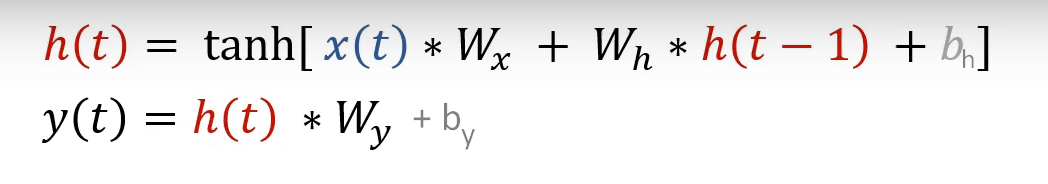
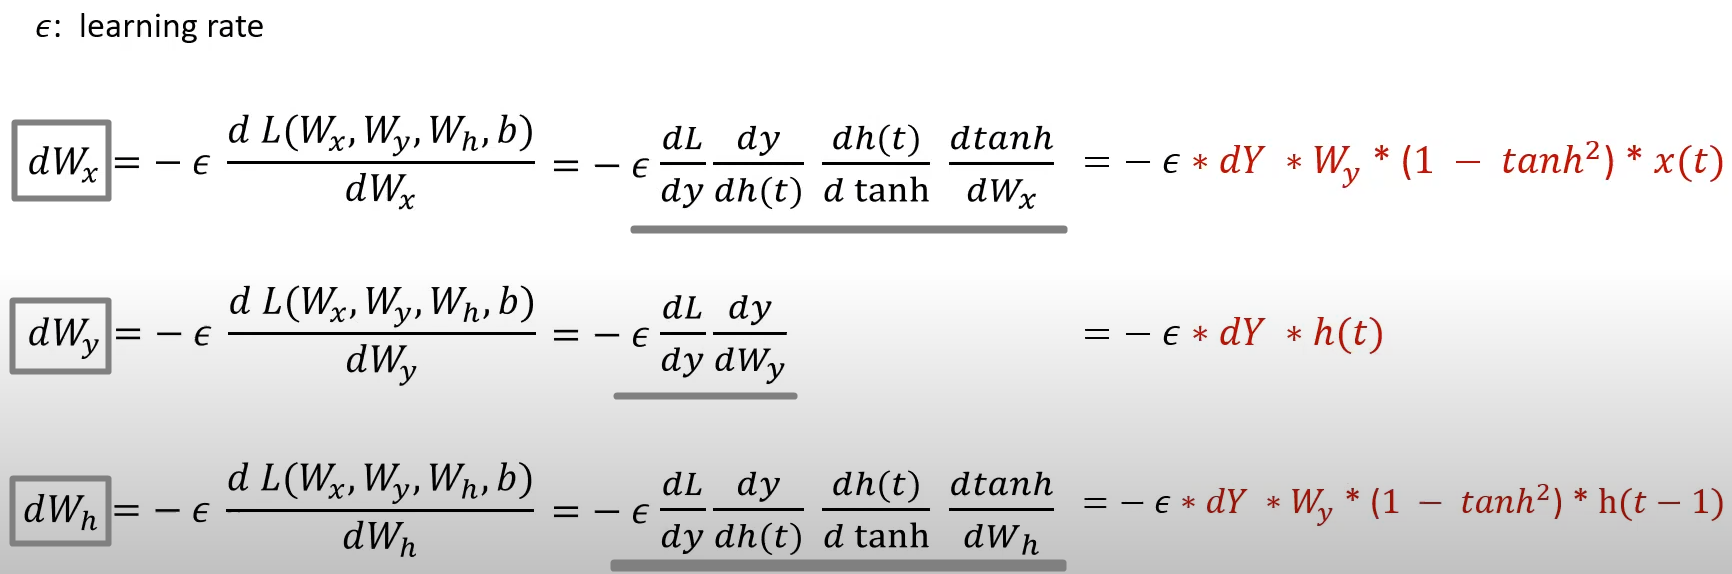

- lets start with tanh, we need to define forward pass and backward pass seperately from rest of the Cell, to make it more managable and modular

In [6]:
class TanhAct:
    def forward(self,input):
        self.input = input
        self.output = np.tanh(self.input)
        return self.output

    def backward(self,d_in):
        """here d_values is the previous layer in derivative chain"""
        #assert self.output is not None
        d_tanh = 1- self.output**2
        self.d_out = np.multiply(d_tanh,d_in)
        return self.d_out

### to continue modularizing our implementation, lets seperate the Cell and Architecture logics

In [7]:
class VanillaRNN:    
    def __init__(self, X_t:np.ndarray, n_neurons:int,Act):
        """
        Parameters:
        X_t (numpy.ndarray): Input time-series data of shape (T, input_size), where T is the number of time steps.
        n_neurons (int): Number of neurons in the hidden layer.
        """
        self.T, self.input_size = X_t.shape # of time steps & # of features in the input
        # here input size like price: 1 or  (temperature and humidity) : 2
        # or for Word Sequence Data : dimensionality of the word embeddings
        self.n_neurons = n_neurons # hidden_size = # of units in the RNN cell layer
        self.X_t = X_t  
        self.Y_hat = np.zeros((self.T,1))# we are predicting T scalar y's, it could be 
        # like outputting a word vector like #T y's of dim output_size.

        # Initialize the hidden states for all time steps (plus one for initial state)
        self.H = [np.zeros((self.n_neurons,1)) for _ in range(self.T + 1)]

        # initialize the weights: Xavier initialization, to keep the gradient scale roughly the same across layers
        # Using Xavier initialization is particularly common in networks with sigmoid or tanh activation functions,
        # where maintaining the variance across layers helps in keeping the neural network activations and gradients stable
        self.Wx = np.random.randn(self.n_neurons, self.input_size) * np.sqrt(1. / self.input_size)
        self.Wh = np.random.randn(self.n_neurons, self.n_neurons) * np.sqrt(1. / self.n_neurons)
        self.Wy = np.random.randn(1, self.n_neurons) * np.sqrt(1. / self.n_neurons)
        self.bh = np.zeros((self.n_neurons, 1))
        self.by = np.zeros((1, 1))
        self.activations = [Act() for _ in range(self.T)]

    def forward(self,) -> Tuple[np.ndarray, np.ndarray]:        
        self._cell_pass()

    def _cell_pass(self):
        # full forward pass of the RNN cell, thru all the time steps
        for t in range(self.T):
            x_t = self.X_t[t].reshape(1,1)
            out = np.dot(self.Wx,x_t) + np.dot(self.Wh,self.H[t])+ self.bh
            # hidden state at time: t (t-1 + 1)
            self.activations[t].forward(out)
            self.H[t+1] = self.activations[t].output
            self.Y_hat[t] = np.dot(self.Wy,self.H[t+1]) + self.by
    

    def backward(self,d_ys):
        """
        - start from the last dy, d_ys[-1]
        - traverse the network, calculate each partial weight & bias derivative 
        - update them
        """    
        self.dWx = np.zeros_like(self.Wx)
        self.dWh = np.zeros_like(self.Wh)
        self.dWy = np.zeros_like(self.Wy)
        self.dbh = np.zeros_like(self.bh)
        self.dby = np.zeros_like(self.by)
        
        # Initialize gradient of hidden state for the last timestep to zero
        dht_next = np.zeros((self.n_neurons, 1))

        for t in reversed(range(self.T)):
            dy = d_ys[t].reshape(1,1) # Error at output layer at time t
            xt = X_t[t].reshape(1,1)# Input at time t

            # Gradient of loss w.r.t. hidden state h(t), includes contribution from future timestep
            dht = np.dot(self.Wy.T, dy) + dht_next

            # Backward pass through the activation function to get gradients w.r.t. pre-activation
            dtanh = self.activations[t].backward(dht)

            #---GRADIENT ACCUMULATION OF LEARNABLE PARAMETERS---#
            self.dWx += np.dot(dtanh, xt)  # Gradient w.r.t. input weights
            self.dWh += np.dot(dtanh, self.H[t].T)
            self.dWy += np.dot(dy, self.H[t+1].T)
            self.dbh += dtanh  # Gradient w.r.t. hidden biases
            self.dby += dy  # Gradient w.r.t. output biases

            # Update the gradient of the hidden state to be passed to the previous timestep
            dht_next = np.dot(self.Wh.T, dtanh)
            
        # weights' updates are handled by seperate SGD object

        # apply clipped gradients
        for d_p in [self.dWx, self.dWh, self.dWy, self.dbh, self.dby]:
            np.clip(d_p, -1, 1, out=d_p)

    
    def predict(self, X_t):
        self.X_t = X_t
        self.T = X_t.shape[0]
        # Reset hidden states for prediction, initializing them for the new sequence
        #self.H = [np.zeros((self.n_neurons, 1)) for _ in range(self.T + 1)]
        self.forward()
        return self.Y_hat
                

In [8]:
act = TanhAct
model = VanillaRNN(X_t, n_neurons=64,Act=act)
model.forward()

In [9]:
model.H[0].shape, model.Y_hat.shape, model.activations[0].output.shape

((64, 1), (200, 1), (64, 1))

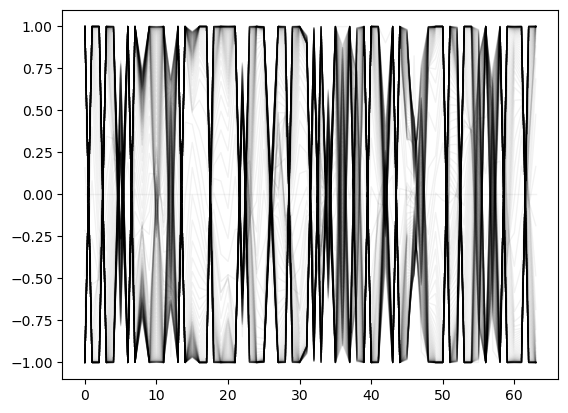

In [10]:
# the very same result, but much more moduler now 
for h in model.H:
    plt.plot(np.arange(64),h,
             'k-',linewidth=1,alpha=0.05)

Epoch: 0, Loss: 0.7660678682050301


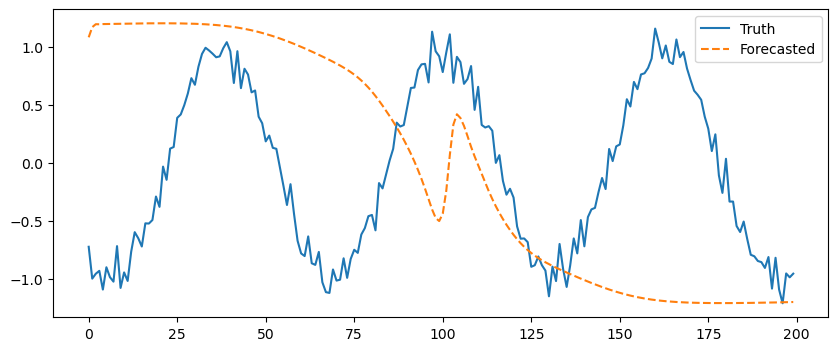

Epoch: 200, Loss: 0.09025888992116066


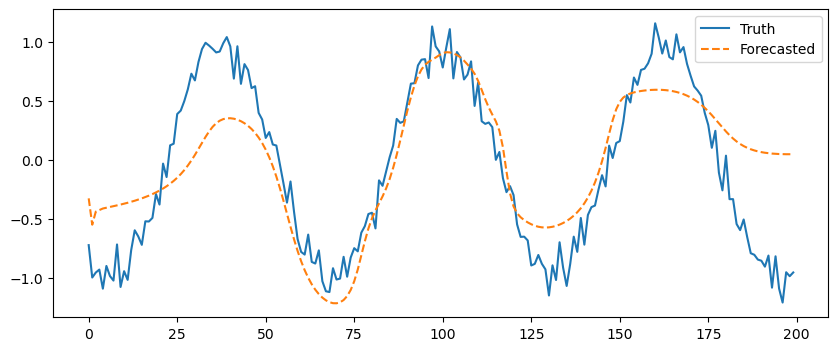

Epoch: 400, Loss: 0.03432564700307806


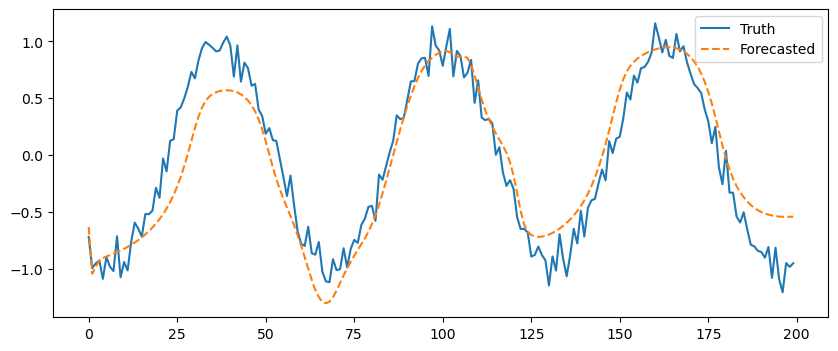

Epoch: 600, Loss: 0.023629290846495617


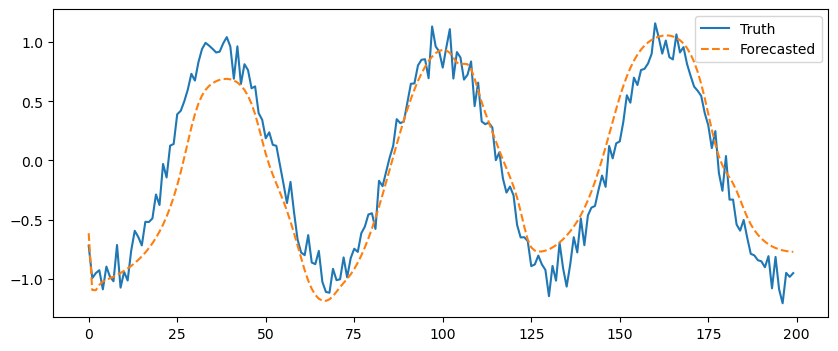

Epoch: 800, Loss: 0.019911564465215133


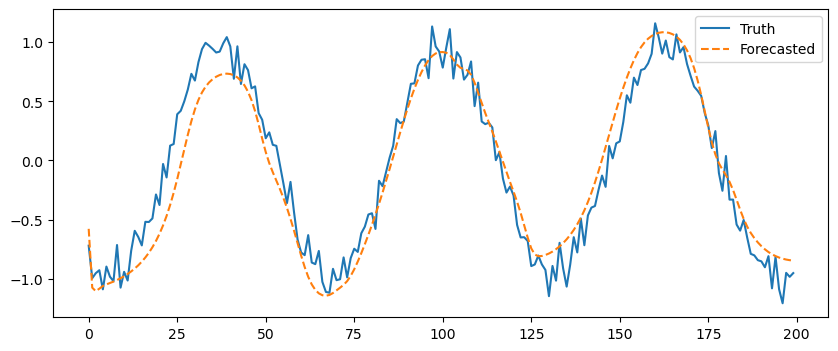

Epoch: 1000, Loss: 0.020681244172298743


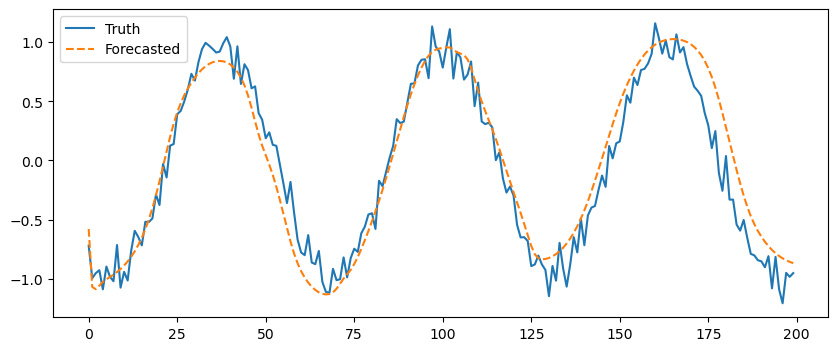

In [11]:
import matplotlib.pyplot as plt

# Example usage
n_neurons = 100
act = TanhAct
model = VanillaRNN(X_t, n_neurons=n_neurons, Act=act)
n_epochs =1000
learning_rate = 0.002

for n in range(n_epochs+1):
    model.forward()

    Y_hat = model.Y_hat
    dY = Y_hat - Y_t.reshape(-1, 1)
    L = 0.5 * np.mean((dY ** 2))  # Mean squared error loss

    # Backward pass
    model.backward(dY)

    # Update weights and biases
    model.Wx -= learning_rate * model.dWx
    model.Wh -= learning_rate * model.dWh
    model.Wy -= learning_rate * model.dWy
    model.bh -= learning_rate * model.dbh
    model.by -= learning_rate * model.dby

    if n % 200 ==0:
        print(f"Epoch: {n}, Loss: {L}")
        plt.figure(figsize=(10, 4))
        plt.plot(Y_t, label="Truth")
        plt.plot(Y_hat, label="Forecasted", linestyle='--')
        plt.legend()
        plt.show()


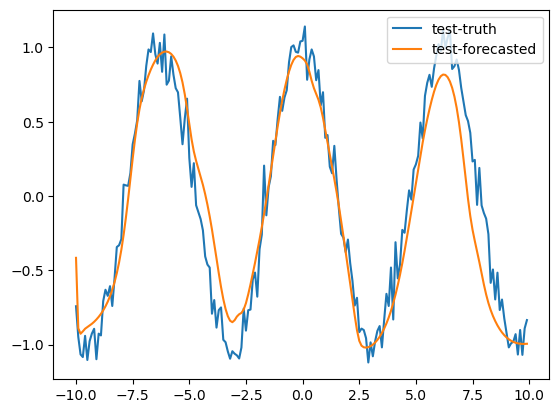

In [12]:
# predict the test data
X_test = np.arange(-10,10,0.1).reshape(-1,1)
Y_test = np.cos(X_test) + 0.1*np.random.randn(X_test.shape[0],1)

y_pred = model.predict(X_test)[:len(X_test)]
# plot Y_test vs y_pred
plt.plot(X_test,Y_test)
plt.plot(X_test,y_pred)

plt.legend(["test-truth","test-forecasted"])

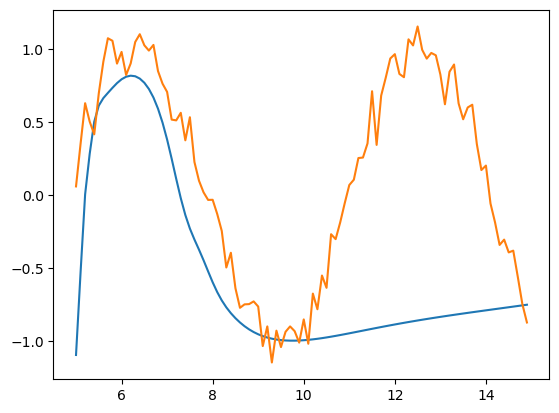

In [14]:
X_test = np.arange(5,15,0.1).reshape(-1,1)
Y_test = np.cos(X_test) + 0.1*np.random.randn(X_test.shape[0],1)
pred = model.predict(X_test)[:len(X_test)]
plt.plot(X_test,pred)
plt.plot(X_test,Y_test)

### introducing stochastic gradient descent (not finished yet, has a subtle bug in handling Tanh states)

In [21]:
import numpy as np
from typing import Tuple

class VanillaRNN2:
    def __init__(self, n_neurons: int, input_size: int, output_size: int, Act):
        """
        Parameters:
        n_neurons (int): Number of neurons in the hidden layer.
        input_size (int): The number of features in the input data.
        output_size (int): The number of features in the output data.
        Act: Activation function class.
        """
        self.n_neurons = n_neurons
        self.input_size = input_size
        self.output_size = output_size

        # Initialize weights and biases
        self.Wx = np.random.randn(n_neurons, input_size) * np.sqrt(1. / input_size)
        self.Wh = np.random.randn(n_neurons, n_neurons) * np.sqrt(1. / n_neurons)
        self.Wy = np.random.randn(output_size, n_neurons) * np.sqrt(1. / n_neurons)
        self.bh = np.zeros((n_neurons, 1))
        self.by = np.zeros((output_size, 1))
        self.Act = Act

    def forward(self, X_t: np.ndarray) -> np.ndarray:
        """
        Perform the forward pass for the entire sequence.
        
        Parameters:
        X_t (numpy.ndarray): Input batch of shape (batch_size, T, input_size)
        
        Returns:
        np.ndarray: The batch of outputs for each time step (batch_size, T, output_size)
        """
        batch_size, T, _ = X_t.shape
        self.H = np.zeros((batch_size, T + 1, self.n_neurons))
        Y_hat = np.zeros((batch_size, T, self.output_size))
        
        activations = [self.Act() for _ in range(T)]
        
        for t in range(T):
            X_step = X_t[:, t, :]
            H_prev = self.H[:, t, :]
            out = np.dot(X_step, self.Wx.T) + np.dot(H_prev, self.Wh.T) + self.bh.T
            H_next = activations[t].forward(out)
            self.H[:, t + 1, :] = H_next
            Y_hat[:, t, :] = np.dot(H_next, self.Wy.T) + self.by.T
        
        return Y_hat

    def backward(self, X_t: np.ndarray, dY: np.ndarray):
        """
        Perform the backward pass for the entire sequence.
        
        Parameters:
        X_t (numpy.ndarray): Input data of shape (batch_size, T, input_size)
        dY (numpy.ndarray): Gradient of the loss with respect to Y_hat (batch_size, T, output_size)
        """
        batch_size, T, _ = X_t.shape
        dWx = np.zeros_like(self.Wx)
        dWh = np.zeros_like(self.Wh)
        dWy = np.zeros_like(self.Wy)
        dbh = np.zeros_like(self.bh)
        dby = np.zeros_like(self.by)
        
        dH_next = np.zeros((batch_size, self.n_neurons))
        activations = [self.Act() for _ in range(T)]
        
        for t in reversed(range(T)):
            dy = dY[:, t, :]
            H_prev = self.H[:, t, :]
            H_next = self.H[:, t + 1, :]
            
            dWy += np.dot(dy.T, H_next)
            dby += np.sum(dy, axis=0).reshape(self.by.shape)
            
            dH = np.dot(dy, self.Wy) + dH_next
            dH *= activations[t].backward(H_next)  # Element-wise multiplication for gradient
            
            dbh += np.sum(dH, axis=0).reshape(self.bh.shape)
            dWx += np.dot(dH.T, X_t[:, t, :])
            dWh += np.dot(dH.T, H_prev)
            
            dH_next = np.dot(dH, self.Wh)
        
        # Gradient clipping
        np.clip(dWx, -1, 1, out=dWx)
        np.clip(dWh, -1, 1, out=dWh)
        np.clip(dWy, -1, 1, out=dWy)
        np.clip(dbh, -1, 1, out=dbh)
        np.clip(dby, -1, 1, out=dby)

        return dWx, dWh, dWy, dbh, dby

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class TanhAct:
    def forward(self, z):
        self.output = np.tanh(z)
        return self.output
    
    def backward(self, dA):
        return dA * (1 - self.output ** 2)


def create_minibatches(X, Y, batch_size):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    X_shuffled = X[indices]
    Y_shuffled = Y[indices]
    
    for start_idx in range(0, X.shape[0] - batch_size + 1, batch_size):
        batch_indices = indices[start_idx:start_idx + batch_size]
        yield X_shuffled[batch_indices], Y_shuffled[batch_indices]

# Example usage
n_neurons = 100
input_size = 1  
output_size = 1  
batch_size = 16
n_epochs = 1000
learning_rate = 0.002

model = VanillaRNN2(n_neurons=n_neurons, input_size=input_size, output_size=output_size, Act=TanhAct)


num_samples = 600
T = 10  
X_t = np.random.randn(num_samples, T, input_size)
Y_t = np.sin(X_t)

# Training loop
for epoch in range(n_epochs + 1):
    epoch_loss = 0
    for X_batch, Y_batch in create_minibatches(X_t, Y_t, batch_size):
   
        Y_hat = model.forward(X_batch)
        
    
        dY = Y_hat - Y_batch
        loss = 0.5 * np.mean(dY ** 2)
        epoch_loss += loss
  
        model.backward(X_batch, dY)
   
        model.Wx -= learning_rate * model.dWx
        model.Wh -= learning_rate * model.dWh
        model.Wy -= learning_rate * model.dWy
        model.bh -= learning_rate * model.dbh
        model.by -= learning_rate * model.dby

    if epoch % 200 == 0:
        print(f"Epoch: {epoch}, Loss: {epoch_loss / (num_samples // batch_size)}")
        plt.figure(figsize=(10, 4))
        plt.plot(Y_t[0, :, 0], label="Truth")
        plt.plot(Y_hat[0, :, 0], label="Forecasted", linestyle='--')
        plt.legend()
        plt.show()

### now to extend the modularity, lets build our own SGD Optimizer class with weight decay and momentum options.

In [18]:
class Optimizer_SGD:
    """
    similar to Torch optimizers
    """
    
    def __init__(self, learning_rate:float=1e-5, decay_rate:float=0.0,momentum:float=0.0):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay_rate = decay_rate
        self.iter = 0
        self.momentum = momentum



    def pre_params_update(self):
        if self.decay_rate:
            self.current_learning_rate = self.learning_rate * \
                (1/ (1 + self.decay_rate*self.iter))
        
    def params_update(self, layer):
        
        if self.momentum:
            #check if layer has attribute "momentum"
            if not hasattr(layer, 'Wx_momentums'):
                layer.Wx_momentums = np.zeros_like(layer.Wx)
                layer.Wy_momentums = np.zeros_like(layer.Wy)
                layer.Wh_momentums = np.zeros_like(layer.Wh)
                layer.bh_momentums = np.zeros_like(layer.bh)
                layer.by_momentums = np.zeros_like(layer.by)

            
            Wx_updates = self.momentum * layer.Wx_momentums - \
                self.current_learning_rate * layer.dWx
            layer.Wx_momentums = Wx_updates
            
            Wy_updates = self.momentum * layer.Wy_momentums - \
                self.current_learning_rate * layer.dWy
            layer.Wy_momentums = Wy_updates
            
            Wh_updates = self.momentum * layer.Wh_momentums - \
                self.current_learning_rate * layer.dWh
            layer.Wh_momentums = Wh_updates
            
            bh_updates = self.momentum * layer.bh_momentums - \
                self.current_learning_rate * layer.dbh
            layer.bh_momentums = bh_updates

            by_updates = self.momentum * layer.by_momentums - \
                self.current_learning_rate * layer.dby
            layer.by_momentums = by_updates
            
        else:
            # classical weight update
            Wx_updates     = -self.current_learning_rate * layer.dWx
            Wy_updates     = -self.current_learning_rate * layer.dWy
            Wh_updates     = -self.current_learning_rate * layer.dWh
            bh_updates   = -self.current_learning_rate * layer.dbh
            by_updates   = -self.current_learning_rate * layer.dby

        
        layer.Wx      += Wx_updates 
        layer.Wy      += Wy_updates 
        layer.Wh      += Wh_updates 
        layer.bh  += bh_updates 
        layer.by  += by_updates 
        
    def post_params_update(self):
        self.iter += 1

    def step(self, layer):
        """Executes one step of parameter update."""
        self.pre_params_update()
        self.params_update(layer)
        self.post_params_update()


Epoch: 0, Loss: 0.9629096461973629


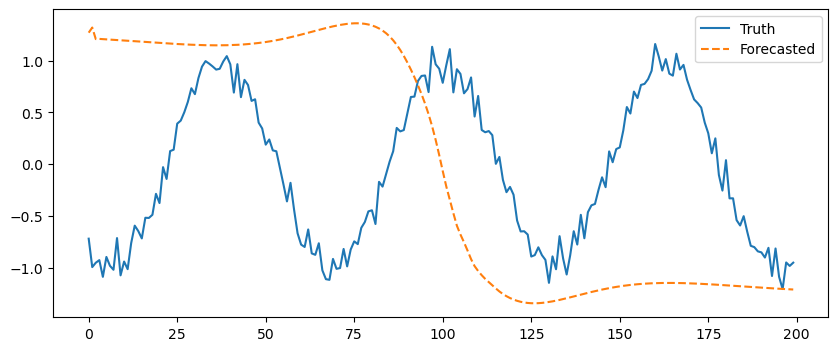

Epoch: 200, Loss: 0.013591174501406122


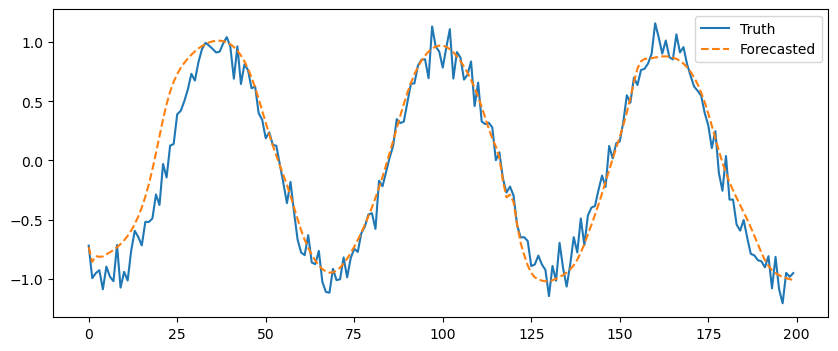

Epoch: 400, Loss: 0.004807872666192653


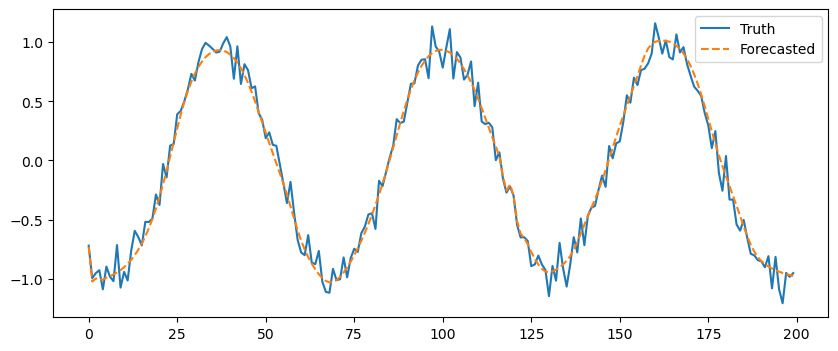

Epoch: 600, Loss: 0.004434576889046


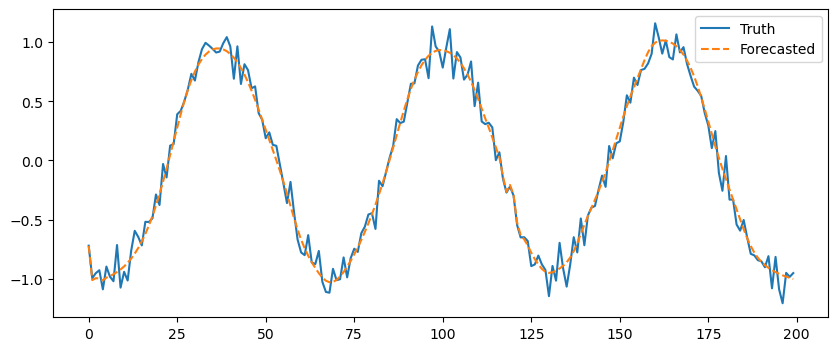

Epoch: 800, Loss: 0.0042995690093387854


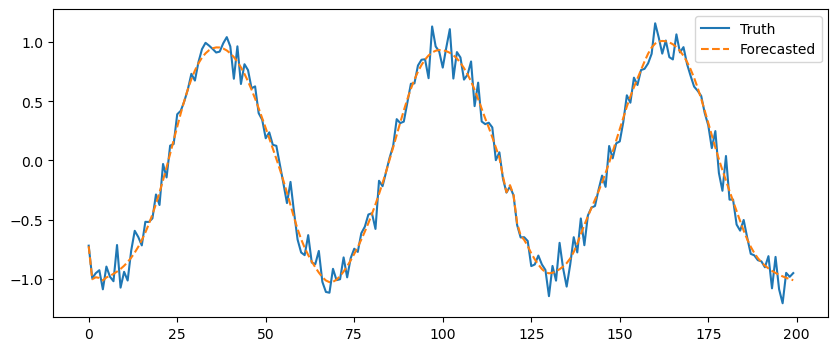

Epoch: 1000, Loss: 0.004246480737016642


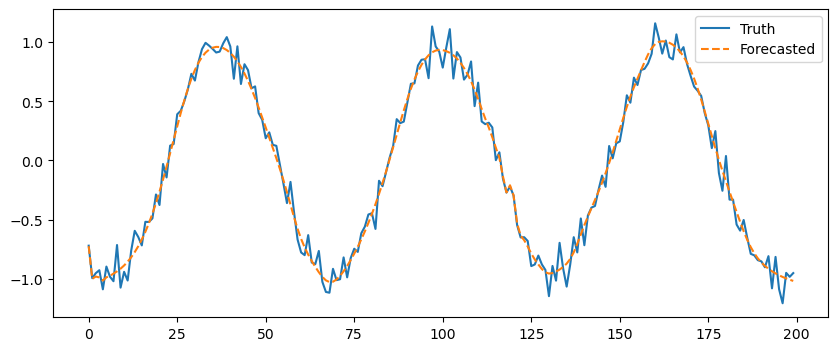

In [19]:
# now lets utilize this SGD as optimizer in our training loop

n_neurons = 100
act = TanhAct
model = VanillaRNN(X_t, n_neurons=n_neurons, Act=act)
n_epochs = 1000
optimizer = Optimizer_SGD(learning_rate=0.002, decay_rate=0.01, momentum=0.9)

for n in range(n_epochs + 1):
    model.forward()

    Y_hat = model.Y_hat
    dY = Y_hat - Y_t.reshape(-1, 1)
    L = 0.5 * np.mean((dY ** 2))  # Mean squared error loss

    model.backward(dY)

    # Update weights and biases using the optimizer
    optimizer.step(model)

    if n % 200 == 0:
        print(f"Epoch: {n}, Loss: {L}")
        plt.figure(figsize=(10, 4))
        plt.plot(Y_t, label="Truth")
        plt.plot(Y_hat, label="Forecasted", linestyle='--')
        plt.legend()
        plt.show()


### so far, we assumed that X_t will provide information about Y and havent used the previous Y_t's as feature. lets implement this and compare its affect on  generalization ability